# Set up environment

In [0]:
import os
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import pandas as pd

import gzip
import _pickle as cPickle
from collections import Counter

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.neighbors import KDTree

from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils
# from keras_gpt_2 import load_trained_model_from_checkpoint, get_bpe_from_files, generate
from keras.models import Model
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
# import shap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [0]:
pad_maxlen = 20
encoding_mode = "tokenize" ## "tokenize", "bpe"

# Get data

In [0]:
df_data = pd.read_csv("data/merge_data.csv")
print (df_data.dtypes)

df_data.head()

Unnamed: 0      int64
date           object
sign          float64
words          object
Open          float64
diff_price    float64
dtype: object


,Unnamed: 0,date,sign,words,Open,diff_price
0,0,2017-05-24,1.0,"[18, 798, 5784, 1684, 454, 2394, 1034, 225, 57...",111.8,0.06
1,1,2017-05-24,1.0,"[27, 5787, 1768, 131, 1403, 5788, 2458, 1, 14,...",111.8,0.06
2,2,2017-05-24,1.0,"[144, 737, 78, 5790, 1367, 5791, 144, 737, 5792]",111.8,0.06
3,3,2017-05-24,1.0,"[2439, 1401, 319, 1310, 22, 5793, 1685, 942, 1...",111.8,0.06
4,4,2017-05-24,1.0,"[5799, 5800, 433, 771, 1433, 13, 2126, 2, 46, ...",111.8,0.06


In [0]:
df_data["sign"].unique()

array([1., 2.])

In [0]:
df_data["item"] = 0
df_data["item"] = df_data.groupby(["date"])["item"].transform("count")
df_data.head(10)

,Unnamed: 0,date,sign,words,Open,diff_price,item
0,0,2017-05-24,1.0,"[18, 798, 5784, 1684, 454, 2394, 1034, 225, 57...",111.80,0.06,5
1,1,2017-05-24,1.0,"[27, 5787, 1768, 131, 1403, 5788, 2458, 1, 14,...",111.80,0.06,5
2,2,2017-05-24,1.0,"[144, 737, 78, 5790, 1367, 5791, 144, 737, 5792]",111.80,0.06,5
3,3,2017-05-24,1.0,"[2439, 1401, 319, 1310, 22, 5793, 1685, 942, 1...",111.80,0.06,5
4,4,2017-05-24,1.0,"[5799, 5800, 433, 771, 1433, 13, 2126, 2, 46, ...",111.80,0.06,5
5,5,2017-05-25,2.0,"[505, 857, 356, 866, 41, 60, 555, 611, 1056, 4...",111.86,-0.94,4
6,6,2017-05-25,2.0,"[733, 315, 5774, 290, 761, 5775, 2270, 908, 14...",111.86,-0.94,4
7,7,2017-05-25,2.0,"[155, 5778, 1517, 704, 11, 5779, 5780, 481, 20...",111.86,-0.94,4
8,8,2017-05-25,2.0,"[105, 232, 1392, 87, 1456, 1448, 584, 60, 64, ...",111.86,-0.94,4
9,9,2017-05-26,1.0,"[387, 2429, 765, 2327, 239, 5757, 5758, 5759, ...",110.92,0.41,4


In [0]:
# seperate train, validate, test datasets
if encoding_mode == "tokenize":
    x_train, x_test0, y_train, y_test0 = train_test_split(
        df_data["words"].apply(eval).values, df_data["sign"].values, test_size=0.30, random_state=42, shuffle=False)
    print (len(df_data["words"].apply(eval).values))    
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
    print('Pad sequences (samples x time)')
    # pad sequences
    x_train = sequence.pad_sequences(x_train, maxlen=pad_maxlen)
    x_validate = sequence.pad_sequences(x_validate, maxlen=pad_maxlen)
    x_test = sequence.pad_sequences(x_test, maxlen=pad_maxlen)
    print('x_train shape:', x_train.shape)
    print('x_validate shape:', x_validate.shape)
    print('x_test shape:', x_test.shape)    
elif encoding_mode == "bpe":
    encode_data = df_data["bpe"].apply(eval).values
    x_train, x_test0, y_train, y_test0 = train_test_split(
        encode_data, df_data["sign"].values, test_size=0.33, random_state=42, shuffle=False)  
    print (len(df_data["bpe"].apply(eval).values))    
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
    text_lens = [len(encode) for encode in x_train]
    max_len = max(text_lens)
    print ("maxlen", max_len)  
    # pad sequence
    x_train =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_train])
    x_validate =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_validate])
    x_test =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_test])
elif encoding_mode == "text":
    encode_data = df_data["bpe"].apply(eval).values
    x_train, x_test0, y_train, y_test0 = train_test_split(
        encode_data, df_data["sign"].values, test_size=0.33, random_state=42, shuffle=False)  
    print (len(df_data["bpe"].apply(eval).values))    
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
    text_lens = [len(encode) for encode in x_train]
    max_len = max(text_lens)
    print ("maxlen", max_len)  
    # pad sequence
    x_train =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_train])
    x_validate =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_validate])
    x_test =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_test])
    
print (x_train.shape, x_validate.shape, x_test.shape)

554
Pad sequences (samples x time)
x_train shape: (387, 20)
x_validate shape: (83, 20)
x_test shape: (84, 20)
(387, 20) (83, 20) (84, 20)


In [0]:
x_train

array([[   0,    0,    0, ..., 1981,  163,   13],
       [   0,    0,    0, ...,   14, 5789, 2458],
       [   0,    0,    0, ...,  144,  737, 5792],
       ...,
       [   0,    0,    0, ...,   63,  190, 2186],
       [   0,    0,    0, ...,  956, 4131, 4132],
       [   0,    0,    0, ..., 4134,  988, 4135]], dtype=int32)

In [0]:
class_vectors = df_data["diff_price"].unique()
len(class_vectors), class_vectors

(119, array([ 0.06, -0.94,  0.41, -0.28,  0.28,  0.39, -0.49,  0.93,  0.26,
        -0.48,  0.18,  0.13, -0.45,  1.55, -0.35,  0.57, -0.44,  0.02,
         0.09,  0.48,  0.04,  0.45,  0.25, -0.47, -0.17,  0.55,  0.1 ,
        -0.89, -0.76, -0.25, -0.29, -0.74, -0.9 ,  0.73,  0.43, -0.68,
        -0.2 ,  0.42, -0.54,  0.78, -0.3 ,  0.08, -0.81,  0.65,  0.67,
        -0.97, -0.11,  0.29,  0.03,  0.19, -0.33, -0.65,  1.3 ,  0.76,
        -0.53, -0.56, -0.16, -0.63,  0.11, -1.17,  0.79,  1.21,  0.37,
         0.35,  0.81,  0.05, -0.34,  1.12, -0.47,  0.08, -0.38,  1.16,
        -0.09,  0.38,  0.14, -0.51,  0.34, -0.35, -0.22, -0.15, -0.31,
         0.36,  0.58, -0.08,  0.71,  0.57, -0.3 ,  0.56, -0.55,  0.37,
        -0.41, -0.43,  0.78, -0.01,  0.07, -0.43, -0.26,  0.01,  0.44,
        -1.03, -0.45, -0.51, -0.74,  0.02,  1.  ,  0.4 , -0.27,  0.49,
         0.87, -0.12, -0.1 , -0.54, -0.63,  0.51, -0.14, -0.09, -0.41,
        -0.18, -0.21]))

## Label encoder

In [0]:
from sklearn.preprocessing import LabelEncoder

# Encode text to labels
le = LabelEncoder()
le.fit(y_train)
train_labels_enc = le.transform(y_train)
validation_labels_enc = le.transform(y_validate)
test_labels_enc = le.transform(y_test)

print (y_train[0:4], train_labels_enc[0:4])
print (train_labels_enc.shape, test_labels_enc.shape)

[1. 1. 1. 1.] [0 0 0 0]
(387,) (84,)


In [0]:
from keras.utils import to_categorical

# Convert a vector label to matrix label
y_train_ohe = to_categorical(train_labels_enc)
y_validation_ohe = to_categorical(validation_labels_enc)
y_test_ohe = to_categorical(test_labels_enc)
print (y_train_ohe.shape,y_test_ohe.shape[0])

(387, 2) 84


In [0]:
set(y_train), y_train_ohe

({1.0, 2.0}, array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]

# Common functions

In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
def predict_model_confusion_matrix(x_train, y_train, model):
    
    # load best model weights
#     model.load_weights("output/fx_model.hdf5")
    
    # predict 
    predicted_labels = model.predict_classes(x_train)
    print ("predicted_labels", set(predicted_labels))
    
    true_labels = y_train
    
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(y_train))
    cm = confusion_matrix(y_train, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    return true_labels, predicted_labels

def plot_confusion_matrix(true_labels, predicted_labels):
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    return

In [0]:
def plot_accuracy(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Transfer Learning Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_lenght = len(history.history['acc'])+1
    epoch_list = list(range(1,epoch_lenght))
    
    # Plot accuracy
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epoch_lenght, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    # Plot loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epoch_lenght, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

# Run model

In [0]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

max_features = 20000
batch_size = 32

In [0]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='tanh'))
model.add(Dense(y_train_ohe.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 6         
Total params: 2,691,848
Trainable params: 2,691,848
Non-trainable params: 0
_________________________________________________________________


In [0]:
print (x_train.shape, x_test.shape)
print (y_train_ohe.shape, y_test_ohe.shape)

(387, 20) (84, 20)
(387, 2) (84, 2)


In [0]:
print('Train...')
# checkpoint = ModelCheckpoint(
#     filepath,
#     monitor='val_accuracy',
#     verbose=1,
#     save_best_only=True,
#     mode='max'
# )
# callbacks_list = [checkpoint]

model_history = model.fit(x_train, y_train_ohe,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_validate, y_validation_ohe)
          )
score, acc = model.evaluate(x_validate, y_validation_ohe,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 387 samples, validate on 83 samples
Epoch 1/10
387/387 [==============================] - 2s 4ms/step - loss: 0.6918 - acc: 0.5401 - val_loss: 0.6940 - val_acc: 0.5060
Epoch 2/10
387/387 [==============================] - 1s 1ms/step - loss: 0.6675 - acc: 0.5659 - val_loss: 0.7260 - val_acc: 0.5060
Epoch 3/10
387/387 [==============================] - 1s 1ms/step - loss: 0.6107 - acc: 0.6744 - val_loss: 0.7123 - val_acc: 0.4819
Epoch 4/10
387/387 [==============================] - 0s 1ms/step - loss: 0.4384 - acc: 0.9612 - val_loss: 0.7573 - val_acc: 0.4699
Epoch 5/10
387/387 [==============================] - 0s 1ms/step - loss: 0.3642 - acc: 0.9871 - val_loss: 0.7349 - val_acc: 0.4819
Epoch 6/10
387/387 [==============================] - 0s 1ms/step - loss: 0.3302 - acc: 1.0000 - val_loss: 0.7979 - val_acc: 0.4819
Epoch 7/10
387/387 [==============================] - 0s 1ms/step - loss: 0.3181 - acc: 0.9922 - val_loss: 0.7975 - val_acc: 0.4699
Epoch 8/10
387/387 [==

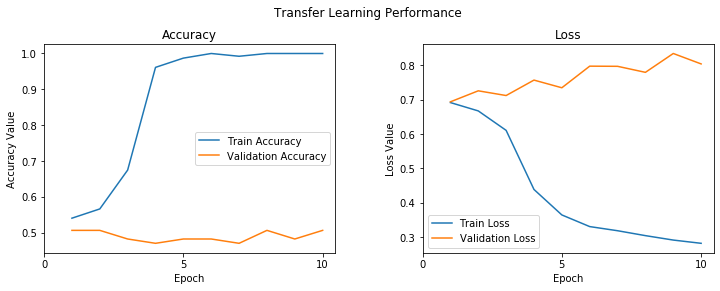

In [0]:
plot_accuracy(model_history)

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


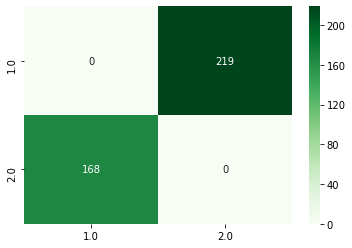

In [0]:
pred_train_model = model.predict_classes(x_train)
pred_train_model_adjust = [x if x == 1 else 2 for x in pred_train_model]
plot_confusion_matrix(y_train, pred_train_model_adjust)

Accuracy: 0.42857142857142855
Precision: 0.4471363594170612
Recall: 0.42857142857142855
F1 Score: 0.4121416249075824


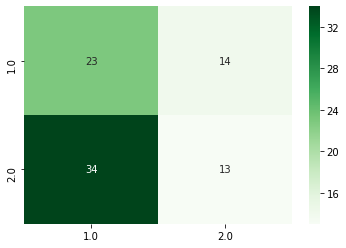

In [0]:
pred_model = model.predict_classes(x_test)
pred_model_adjust = [x if x == 1 else 2 for x in pred_model]
plot_confusion_matrix(y_test, pred_model_adjust)

# Create ZSL model

In [0]:
# CREATE AND SAVE ZSL MODEL
inp         = model.input
out         = model.layers[-2].output
zsl_model   = Model(inp, out)
print(zsl_model.summary())
# save_keras_model(zsl_model, model_path=MODELPATH)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3_input (InputLaye (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
None


## Process zero-shot model

In [0]:
price_vectors = np.array(df_data[["diff_price","item"]])
vectors = np.unique(price_vectors, axis=0)
price_vectors.shape, vectors.shape

((554, 2), (143, 2))

In [0]:
price_vectors

array([[ 0.06,  5.  ],
       [ 0.06,  5.  ],
       [ 0.06,  5.  ],
       ...,
       [-0.21,  4.  ],
       [-0.21,  4.  ],
       [-0.21,  4.  ]])

In [0]:
class_names = [1 if vectors.T[0][i]>0 else 2 for i in range(len(vectors.T[0])) ]
price_class_names = [1 if price_vectors.T[0][i]>0 else 2 for i in range(len(price_vectors.T[0])) ]
print ("class_name: {}, price_class_name: {}".format(len(class_names), len(price_class_names)))

class_name: 143, price_class_name: 554


In [0]:
price_class_names[0:10]

[1, 1, 1, 1, 1, 2, 2, 2, 2, 1]

In [0]:
tree = KDTree(price_vectors)

In [0]:
pred_model_original = model.predict_classes(x_test)
# pred_zsl_original = zsl_model.predict(x_test)
pred_model = [x if x == 1 else 2 for x in pred_model_original]
# pred_zsl = [x if x == 1 else 2 for x in pred_zsl_original.T[0]]
pred_zsl = zsl_model.predict(x_test)
print ("pred_model", len(pred_model))
print ("pred_zsl", len(pred_zsl))


pred_model 84
pred_zsl 84


In [0]:
pred_zsl[0], pred_zsl_original[0]

(array([ 0.9963972, -0.9978589], dtype=float32),
 array([0.01085162, 0.9931613 ], dtype=float32))

In [0]:
print (np.expand_dims(pred_zsl[0], axis=0).shape)
print (np.expand_dims(pred_zsl[10], axis=0).shape)

(1, 2)
(1, 2)


In [0]:
tree.query(np.expand_dims(pred_zsl[1], axis=0), k=5)

(array([[1.87927983, 1.89350586, 1.89350586, 1.91685347, 1.91890117]]),
 array([[354, 530, 104, 130, 486]]))

In [0]:
price_class_names[354], price_class_names[486]

(1, 1)

In [0]:
set(y_test)

{1.0, 2.0}

In [0]:
count_zsl = 0
count_lstm = 0
zsl_prediction = []
lstm_prediction = []
for i, pred in enumerate(pred_zsl):
    dist_5, index_5 = tree.query(np.expand_dims(pred, axis=0), k=5)
    zsl_label     = [price_class_names[index] for index in index_5[0]][0]
    true_label      = int(y_test[i])

    zsl_label = zsl_label if zsl_label==1 else 2
    lstm_label = pred_model[i] if pred_model[i]==1 else 2

    # intregate predicted data
    zsl_prediction.append(zsl_label)
    lstm_prediction.append(lstm_label)
    # print (true_label, pred_labels, pred_lstm)

    if (i==1) :
        print ("dist, index", dist_5, index_5)
        print ("i:{}, true:{}, zsl:{}, lstm:{}".format(i, true_label, zsl_label, lstm_label))
    if true_label == zsl_label:
        count_zsl += 1
    if true_label == lstm_label:
        count_lstm += 1

print("\n==== Compare zsl and lstm")
print("-> zsl : %.2f" % (count_zsl / float(len(x_test))))
print("-> lstm: %.2f" % (count_lstm / float(len(x_test))))

dist, index [[1.87927983 1.89350586 1.89350586 1.91685347 1.91890117]] [[354 530 104 130 486]]
i:1, true:1, zsl:1, lstm:1

==== Compare zsl and lstm
-> zsl : 0.44
-> lstm: 0.43


Accuracy: 0.44047619047619047
Precision: 0.46447772657450076
Recall: 0.44047619047619047
F1 Score: 0.4097601271514315


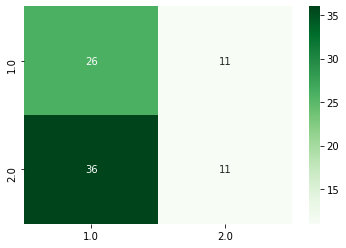

In [0]:
plot_confusion_matrix(y_test, zsl_prediction)

Accuracy: 0.42857142857142855
Precision: 0.4471363594170612
Recall: 0.42857142857142855
F1 Score: 0.4121416249075824


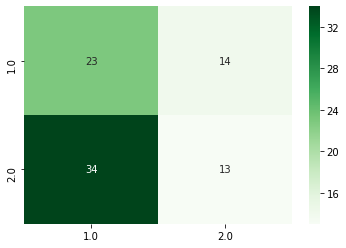

In [0]:
plot_confusion_matrix(y_test, lstm_prediction)